# 프로젝트 : 폐렴 진단기 성능개선

* 좀전까지의 실습 과정을 되짚어보면서, 어떤 점을 좀더 개선해볼 수 있을지 따져 보고 스스로 개선해 가면서 좀더 성능을 향상 시도

## 실험환경 Set-up
거의 바꿔볼 수 있을게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 30

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)

/home/ssac26/aiffel


In [3]:
# tf.io.gfile.glob - 주어진 패턴과 일치하는 파일목록 반환
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
# extend : filenames끝에 해당항목 '모두' 추가(가장 바깥쪽 iterable)
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
#  train : val를 80:20으로 분할
# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# train셋중 노멀과 폐렴이미지 갯수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1087
Pneumonia images count in training set: 3098


In [6]:
# tensor사용해서 데이터셋 불러오기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# train 데이터 셋, validation 데이터 셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
## # os.path.sep - 파일 각 경로를 나눠 리스트로 리턴하기 os.path.sep은 os별 경로 분리자
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# train, val 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* augmentation 기법  
적은양의 훈련데이터에 인위적인 변화를 가해 새로운 훈련데이터 대량 확보

의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## step3. 데이터 시각화

만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.



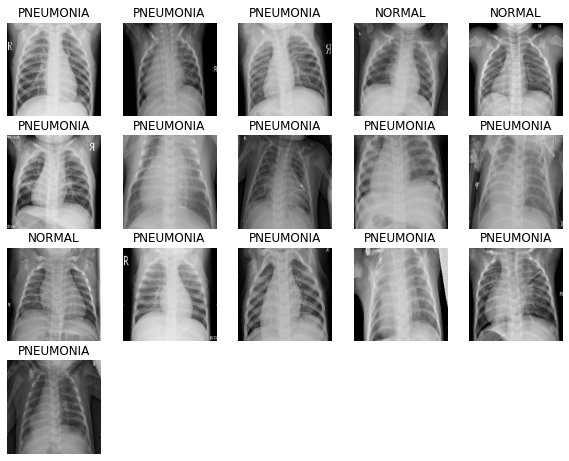

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(64),
        
        conv_block(32),
        tf.keras.layers.Dropout(0.2),
        
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(256, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
acs = build_model()
acs.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 128)       20496     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        14400     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 32)        4128      
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)       

In [20]:
(COUNT_NORMAL/TRAIN_IMG_COUNT)*100

25.973715651135006

In [21]:
round((COUNT_NORMAL/TRAIN_IMG_COUNT)*100,1)


26.0

In [22]:
round((COUNT_PNEUMONIA/TRAIN_IMG_COUNT)*100,1)

74.0

In [23]:
# COUNT_NORMAL/PNEU - 정상, 폐렴 이미지수
# TRAIN_IMG_COUNT - train dataset갯수
# scaling total/2 - 손실을 비슷하게 유지하는데 도움됨
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
# 폐렴이 3배가량 많으므로
# 자료비율 반대로 가중치 수동입력
#class_weight = {0: 0.75, 1: 0.25}
class_weight = {0:weight_for_0,1:weight_for_1}

* 모델 훈련

In [24]:
# from tensorflow.keras import callbacks
# es = callbacks.EarlyStopping(monitor = 'val_loss', verbose=1, mode='min', patience=3)

In [25]:
with tf.device('/GPU:0'):
    model = build_model()
    # with tf.device('/GPU:0'): 첫번째 GPU 사용지정

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, #callbacks = [es]
    )

Epoch 1/30
139/139 [==============================] - 30s 217ms/step - loss: 0.3198 - accuracy: 0.8475 - precision: 0.9517 - recall: 0.8364 - val_loss: 0.5646 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 2/30
139/139 [==============================] - 25s 180ms/step - loss: 0.1740 - accuracy: 0.9319 - precision: 0.9808 - recall: 0.9262 - val_loss: 0.5704 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 3/30
139/139 [==============================] - 25s 181ms/step - loss: 0.1143 - accuracy: 0.9600 - precision: 0.9896 - recall: 0.9559 - val_loss: 0.8176 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 4/30
139/139 [==============================] - 25s 179ms/step - loss: 0.1037 - accuracy: 0.9607 - precision: 0.9877 - recall: 0.9589 - val_loss: 1.1218 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 5/30
139/139 [==============================] - 25s 179ms/step - loss: 0.0899 - accura

* 결과확인

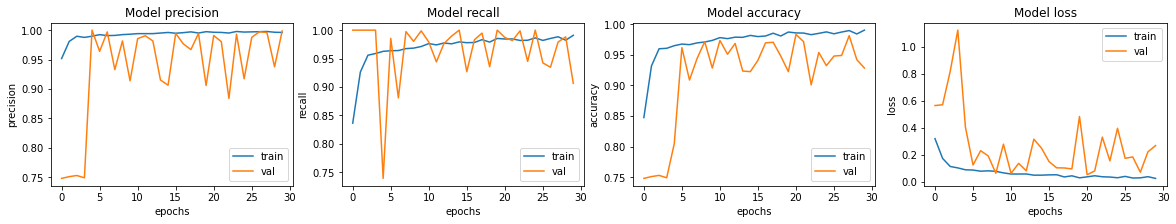

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# val의 변화가 너무 심해서 earlystopping사용 불가해보임
# loss가 완만하게 하강하는 그래프가 아닌 형태
# 배치 노멀사용하는 모델을 만들어봤으나 그래프가 위의 형태보다 더 크게 벗어난 일변도 형태로 나와서
# 기존노드에서 드롭아웃만 사용하는 방향으로 진행함

In [28]:
loss, acc, prec, rec = model.evaluate(test_ds)

21/21 [==============================] - 17s 791ms/step - loss: 0.8546 - accuracy: 0.8253 - precision: 0.8200 - recall: 0.9231


In [29]:
# BN 사용시 dropout 필요없다는 내용 적용시, 이해 부족때문인자
# loss: 1.4944 - accuracy: 0.8045 - precision: 0.7648 - recall: 0.9923
# overfitting같다.